In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import  math
import csv
import os
from google.colab.patches import cv2_imshow

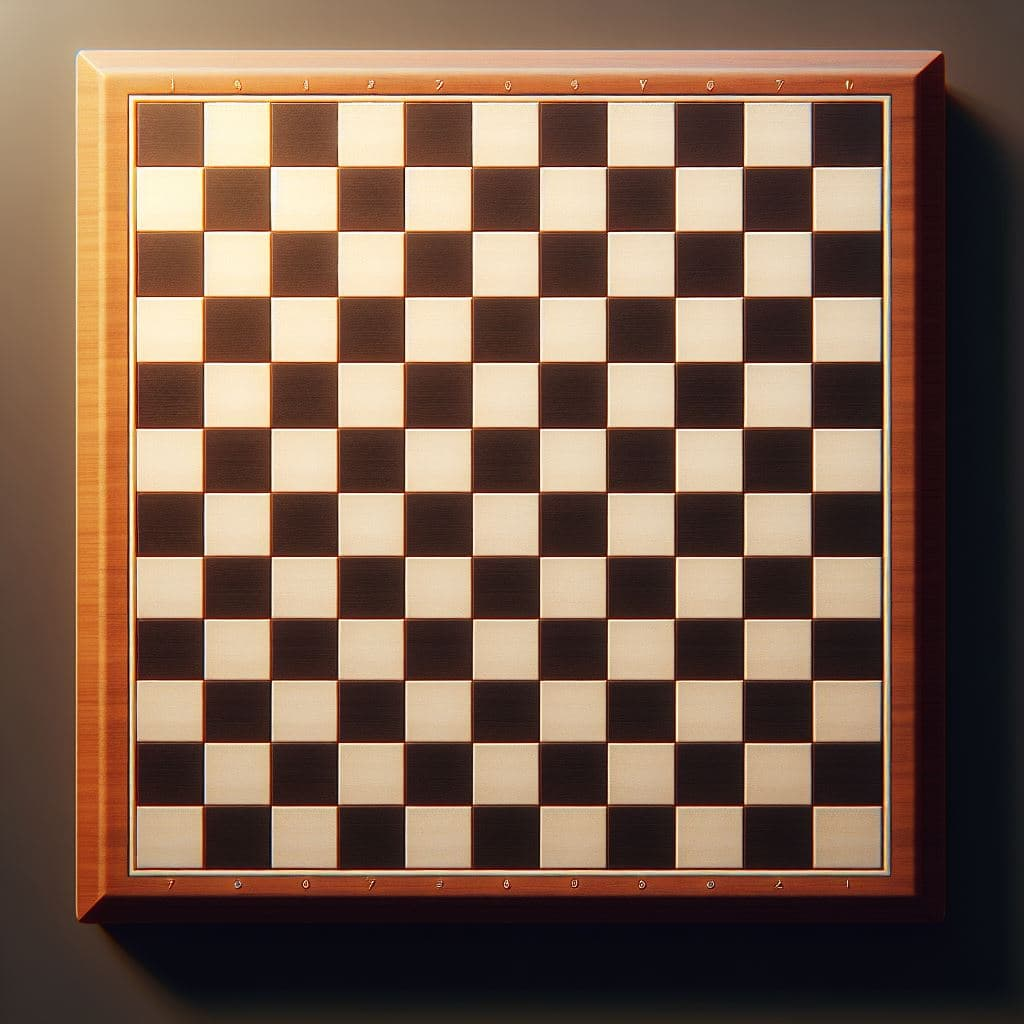

In [57]:
img = cv2.imread('/content/chess image.jpg')
cv2_imshow(img)

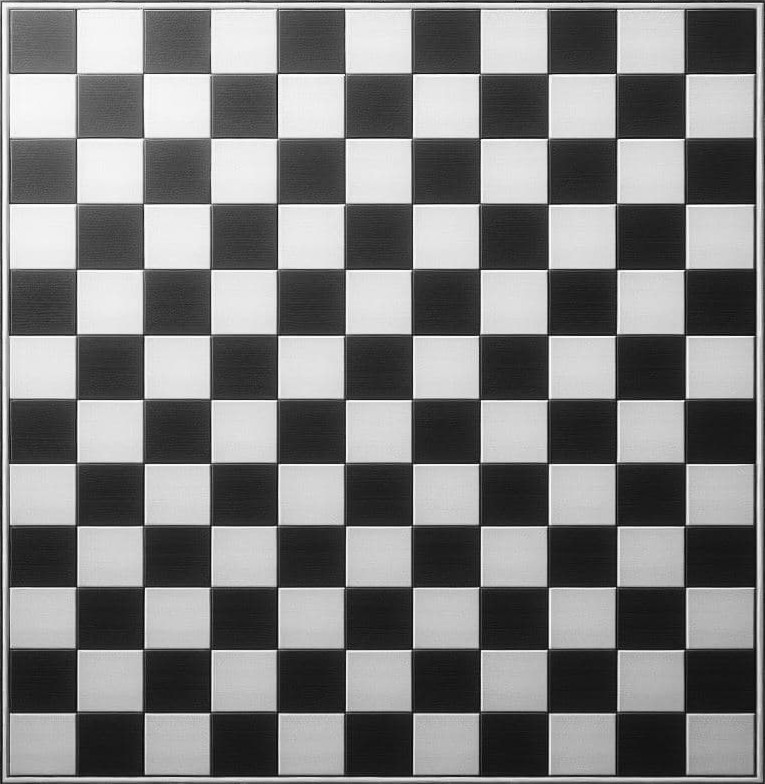

In [41]:
#roi



gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Detect contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Find the largest rectangle assuming it's the chessboard
chessboard_contour = None
max_area = 0

for cnt in contours:
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    if len(approx) == 4:  # Check if contour is a quadrilateral
        area = cv2.contourArea(cnt)
        if area > max_area:  # Keep the largest quadrilateral
            max_area = area
            chessboard_contour = approx

if chessboard_contour is not None:
    # Get bounding box for the chessboard
    x, y, w, h = cv2.boundingRect(chessboard_contour)

    # Crop the image to the chessboard region
    chessboard_roi = gray[y:y+h, x:x+w]
    cv2_imshow(chessboard_roi)
    cv2.imwrite("/content/chessimage7 roi.jpg",chessboard_roi)



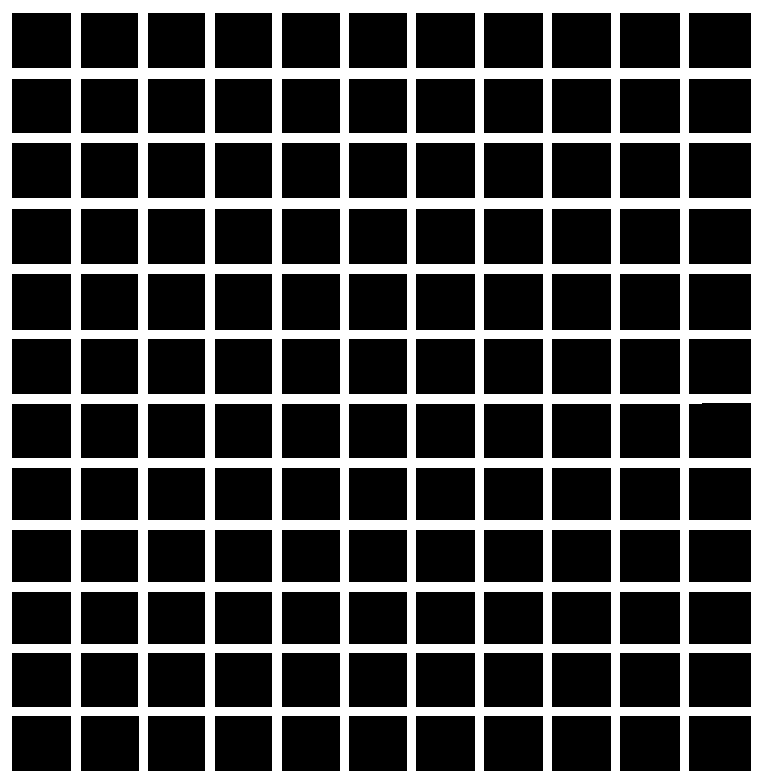

In [44]:

image_path = "/content/chessimage7 roi.jpg"
image = cv2.imread(image_path)

gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
rgb_image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


# Processing Image

# OTSU threshold
ret, otsu_binary = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Canny edge detection
canny = cv2.Canny(otsu_binary, 20, 255)

# Dilation
kernel = np.ones((7, 7), np.uint8)
img_dilation = cv2.dilate(canny, kernel, iterations=1)


# Hough Lines
lines = cv2.HoughLinesP(img_dilation, 1, np.pi / 180, threshold=500, minLineLength=150, maxLineGap=100)

# Create an image that contains only black pixels
black_image = np.zeros_like(img_dilation)

#  draw only lines that are output of HoughLinesP function to the "black_image"
if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # draw only lines to the "black_image"
            cv2.line(black_image, (x1, y1), (x2, y2), (255, 255, 255), 2)

# Dilation
kernel = np.ones((3, 3), np.uint8)
black_image = cv2.dilate(black_image, kernel, iterations=1)

cv2_imshow(black_image)

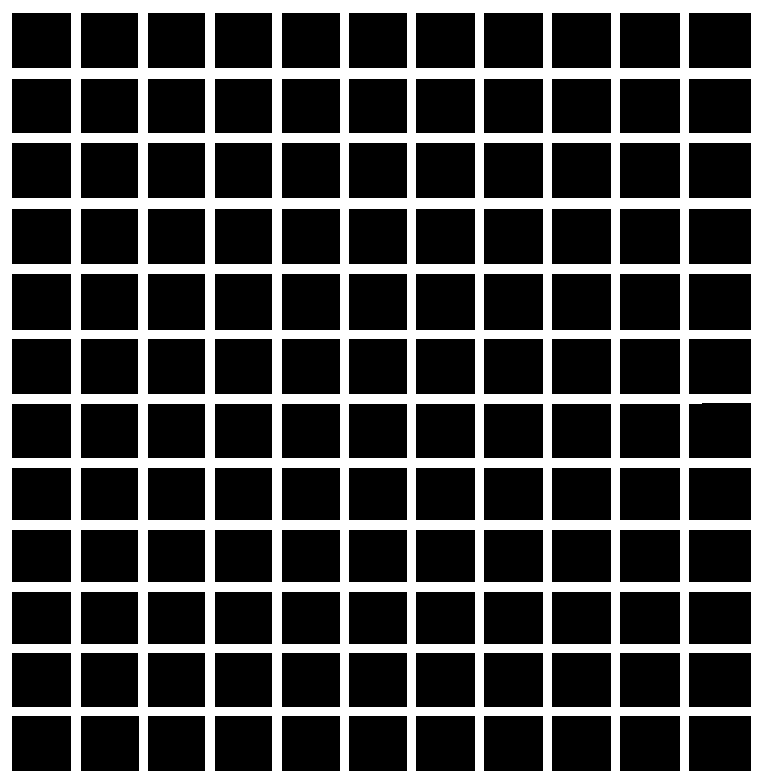

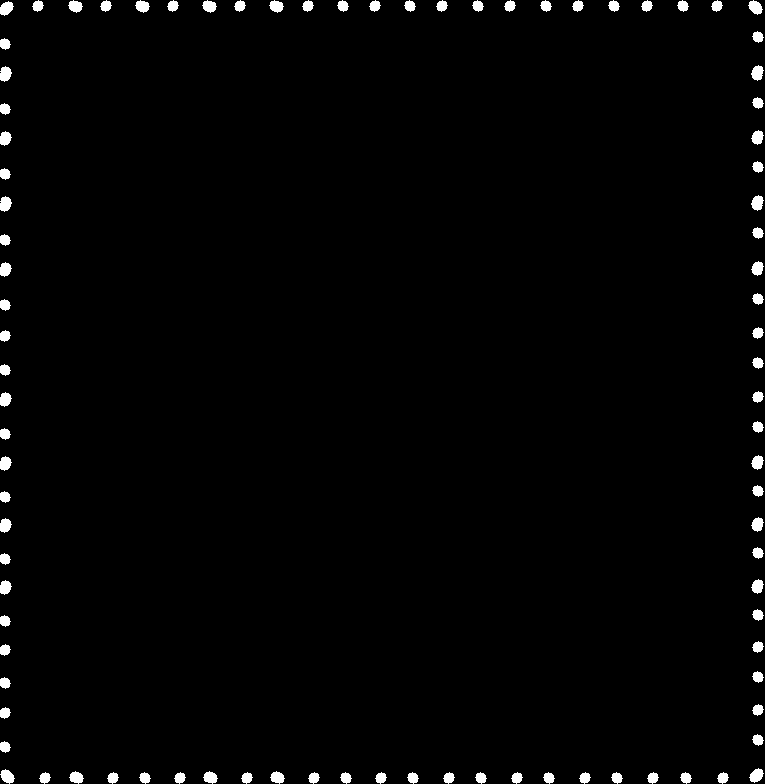

In [46]:

# find contours

board_contours, hierarchy = cv2.findContours(black_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# create image that contains only black pixels
black_image_2 = np.zeros_like(black_image)
cv2_imshow(black_image)

# list for storing the center coordinates of squares
square_centers=list()

# loop through contours and filter them by deciding if they are potential squares
for contour in board_contours:

        if 2000 < cv2.contourArea(contour) < 20000:


            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)


            if len(approx) == 4:


                pts = [pt[0].tolist() for pt in approx]

                # create same pattern for points , bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                index_sorted = sorted(pts, key=lambda x: x[0], reverse=True) # sort X values

                #  Y values
                if index_sorted[0][1]< index_sorted[1][1]:
                    cur=index_sorted[0]
                    index_sorted[0] =  index_sorted[1]
                    index_sorted[1] = cur

                if index_sorted[2][1]> index_sorted[3][1]:
                    cur=index_sorted[2]
                    index_sorted[2] =  index_sorted[3]
                    index_sorted[3] = cur

                # bottomright(1) , topright(2) , topleft(3) , bottomleft(4)
                pt1=index_sorted[0]
                pt2=index_sorted[1]
                pt3=index_sorted[2]
                pt4=index_sorted[3]

                # find rectangle that fits 4 point
                x, y, w, h = cv2.boundingRect(contour)
                # find center of rectangle
                center_x=(x+(x+w))/2
                center_y=(y+(y+h))/2

                # calculate length of 4 side of rectangle
                l1 = math.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
                l2 = math.sqrt((pt2[0] - pt3[0])**2 + (pt2[1] - pt3[1])**2)
                l3 = math.sqrt((pt3[0] - pt4[0])**2 + (pt3[1] - pt4[1])**2)
                l4 = math.sqrt((pt1[0] - pt4[0])**2 + (pt1[1] - pt4[1])**2)


                # Create a list of lengths
                lengths = [l1, l2, l3, l4]

                # Get the maximum and minimum lengths
                max_length = max(lengths)
                min_length = min(lengths)

                # Check if this length values are suitable for a square , this threshold value plays crucial role for squares ,
                valid_square=True
                if (max_length - min_length) <= 35: # 20 for smaller boards  , 50 for bigger , 35 works most of the time
                     pass
                else:
                    valid_square=False

                # if algorithm decides it is a square , add it to "square_centers" list
                if valid_square:
                    square_centers.append([center_x,center_y,pt1,pt2,pt3,pt4])

                    # Draw only valid squares to "black_image_2"
                    cv2.line(black_image_2, pt1, pt2, (255, 255, 0), 7)
                    cv2.line(black_image_2, pt2, pt3, (255, 255, 0), 7)
                    cv2.line(black_image_2, pt3, pt4, (255, 255, 0), 7)
                    cv2.line(black_image_2, pt1, pt4, (255, 255, 0), 7)



 # Apply dilation to the black_image_2
kernel = np.ones((7, 7), np.uint8)
dilated_black_image = cv2.dilate(black_image_2, kernel, iterations=1)


# Find contours of dilated_black_image
contours, _ = cv2.findContours(dilated_black_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


# take biggest contour
largest_contour = max(contours, key=cv2.contourArea)

# create black image
biggest_area_image = np.zeros_like(dilated_black_image)

# draw biggest contour to the image
cv2.drawContours(biggest_area_image,largest_contour,-1,(255,255,255),10)

cv2_imshow(biggest_area_image)

# Check if square centers falls inside of biggest contour , it is for detecting undesired squares that exists outside of the board

inside_squares=list()

for square in square_centers:
    point=(square[0],square[1])

    # Check if the point is inside the largest contour
    distance = cv2.pointPolygonTest(largest_contour, point, measureDist=False)

    if distance >= 0:
        inside_squares.append(square)

    else:
        continue


In [33]:




# sort y values
sorted_coordinates = sorted(inside_squares, key=lambda x: x[1], reverse=True)

# sort x values
groups = []
current_group = [sorted_coordinates[0]]

for coord in sorted_coordinates[1:]:
    if abs(coord[1] - current_group[-1][1]) < 50:
        current_group.append(coord)
    else:
        groups.append(current_group)
        current_group = [coord]


groups.append(current_group)


for group in groups:
    group.sort(key=lambda x: x[0])


sorted_coordinates = [coord for group in groups for coord in group]



In [47]:

# Find missing squares and  fill the board



# Function for finding and filling undetected squares

"""
    This function simply follow coordinates of consequtive squares , but there are some squares that needs to
    handled differently .
    Think about first square of every row , before that square there is nothing, so it shouldnt  processed  like
    consequtive squares
    [6,14,22,30,38,46,54] and [8,16,24,32,40,48,56] , and remaining squares treated differently , for these 3 set, there is 3 different algorithms
    Dont forget : this numbers are started from "0" , so square 6 means 7 in real chess board
"""

def fill_gaps():
    global sorted_coordinates

    addition=0

    for num in range(63):


        if num in [6,14,22,30,38,46,54]:
            if abs(sorted_coordinates[num][0]-sorted_coordinates[num+1][0])>250:

                x=sorted_coordinates[num][0]+ abs(sorted_coordinates[num][0]-sorted_coordinates[num-1][0])
                y=sorted_coordinates[num][1]

                p1=(sorted_coordinates[num][2][0]+ abs(sorted_coordinates[num][2][0]-sorted_coordinates[num-1][2][0]) , sorted_coordinates[num][2][1])
                p2=(sorted_coordinates[num][3][0]+ abs(sorted_coordinates[num][3][0]-sorted_coordinates[num-1][3][0]) , sorted_coordinates[num][3][1])
                p3=sorted_coordinates[num][3]
                p4=sorted_coordinates[num][2]



                sorted_coordinates.insert(num+1,[x,y,p1,p2,p3,p4])

                continue



        elif num in [8,16,24,32,40,48,56]:
            if abs(sorted_coordinates[num][0]-sorted_coordinates[num-8][0])>50:

                x=sorted_coordinates[num-8][0]
                y=sorted_coordinates[num+1][1]
                    # x,y,p1,p2,p3,p4
                p1=sorted_coordinates[num-8][3]
                p2=(sorted_coordinates[num-8][3][0],sorted_coordinates[num+1][3][1])
                p3=(sorted_coordinates[num-8][4][0],sorted_coordinates[num+1][3][1])
                p4=sorted_coordinates[num-8][4]

                sorted_coordinates.insert(num,[x,y,p1,p2,p3,p4])



                continue



        elif abs(sorted_coordinates[num][1] - sorted_coordinates[num+1][1])< 50 :
            if sorted_coordinates[num+1][0] - sorted_coordinates[num][0] > 150:
                x=(sorted_coordinates[num+1][0] + sorted_coordinates[num][0])/2
                y=(sorted_coordinates[num+1][1] + sorted_coordinates[num][1])/2
                p1=sorted_coordinates[num+1][5]
                p2=sorted_coordinates[num+1][4]
                p3=sorted_coordinates[num][3]
                p4=sorted_coordinates[num][2]
                sorted_coordinates.insert(num+1,[x,y,p1,p2,p3,p4])

                addition+=1

    if addition!=0:
        fill_gaps()

fill_gaps()





In [48]:




# Write coordinates to CSV file
with open('/content/abc2.csv', mode='w', newline='') as file:
    writer = csv.writer(file)

    # columns
    writer.writerow(['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'])


    for coordinate in sorted_coordinates:
        writer.writerow([coordinate[2][0], coordinate[2][1],
                                coordinate[3][0], coordinate[3][1],
                                coordinate[4][0], coordinate[4][1],
                                coordinate[5][0], coordinate[5][1]])




<ipython-input-56-816139979837>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pts.append((int(row[j]), int(row[j+1])))
<ipython-input-56-816139979837>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_center = int((row[0] + row[2] + row[4] + row[6]) / 4)
<ipython-input-56-816139979837>:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_center = int((row[1] + row[3] + row[5] + row[7]) / 4)


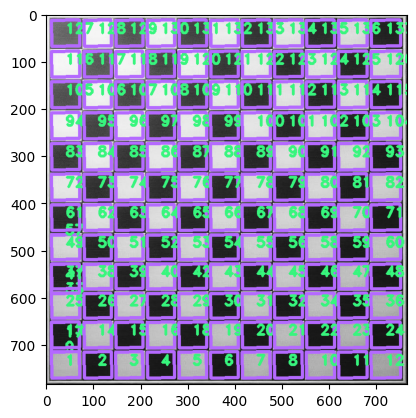

In [56]:

# Load coordinates from CSV file
coordinates = pd.read_csv("/content/abc2.csv")

# Read the image
image = cv2.imread(image_path)


# Dictionary for cell boundary coordinates
coord_dict = {}
cell = 1
for row in coordinates.values:
    coord_dict[cell] = [[row[0], row[1]], [row[2], row[3]], [row[4], row[5]], [row[6], row[7]]]
    cell += 1

# Loop through each row in the DataFrame and draw polygons and cell numbers
square_num = 1
for i, row in coordinates.iterrows():
    # Draw polygon
    pts = []
    for j in range(0, 8, 2):
        pts.append((int(row[j]), int(row[j+1])))
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1, 1, 2))
    cv2.polylines(image, [pts], True, (255, 105, 180), thickness=5)  # Change color and thickness as needed

    # Calculate center of polygon
    x_center = int((row[0] + row[2] + row[4] + row[6]) / 4)
    y_center = int((row[1] + row[3] + row[5] + row[7]) / 4)

    # Draw cell number at center of polygon
    cv2.putText(img=image, text=str(square_num), org=(x_center, y_center),
                fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=1, color=(125, 246, 55), thickness=3)
    square_num += 1

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()